Reference:  
[1] “Pygad.torchga Module¶.” Pygad.torchga Module - PyGAD 2.14.2 Documentation, pygad.readthedocs.io/en/latest/README_pygad_torchga_ReadTheDocs.html. 

In [63]:
# import libraries
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import numpy as np
import math
import pygad
# import pygad.torchga
from pygad import torchga
np.random.seed(0)

##  Load data and pre-process data

             Mean         Std       Diff1       Diff2       PCAd1       PCAd2
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000
mean     0.889090    0.102462    0.008421    0.209575    0.030703    0.121382
std      0.058538    0.083080    0.008153    0.097787    0.014715    0.029972
min      0.582885    0.007986    0.001081    0.021851    0.010325    0.061143
25%      0.852057    0.040081    0.002415    0.114244    0.019492    0.104173
50%      0.897453    0.068729    0.004292    0.234337    0.028206    0.117531
75%      0.934203    0.159266    0.013236    0.290046    0.035855    0.137517
max      0.983422    0.358368    0.044005    0.418234    0.083780    0.239318


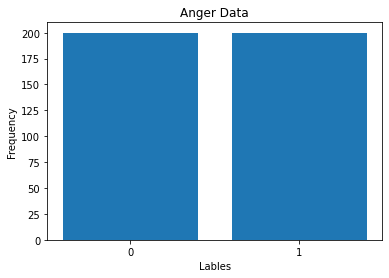

       Mean       Std     Diff1     Diff2     PCAd1     PCAd2  Label  \
0  0.649874  0.505871  0.259093  0.233600  0.096260  0.230412      1   
1  0.689979  0.280722  0.047610  0.483852  0.091571  0.260161      1   
2  0.663444  0.347499  0.130591  0.094757  0.102386  0.265640      1   
3  0.709745  0.254163  0.021826  0.607142  0.096219  0.259239      1   
4  0.896751  0.073727  0.012656  0.695723  0.120547  0.262105      1   

   extraNode  
0   0.000000  
1   0.005025  
2   0.010050  
3   0.015075  
4   0.020101  


In [64]:
# load training data
data= pd.read_excel('Anger.xlsx')

# drop first column as it is identifier and the second column as 
data.drop(data.columns[:2], axis=1, inplace=True)
data.at[data['Label'] == 'Genuine', ['Label']] = 1
data.at[data['Label'] == 'Posed', ['Label']] = 0

print(data.describe())

# Also convert all string numeric values to int
data.iloc[:,2:8]=data.iloc[:, 2:8].apply(pd.to_numeric)

# extract frequency of each class
class_freq = data['Label'].value_counts()
class_freq = list(class_freq.sort_index())

# visualize distribution of data
# x-axis labels and length
x_axis = list(range(0,2))

graph = plt.bar(x_axis, class_freq)
plt.xticks(x_axis)
plt.ylabel('Frequency')
plt.xlabel('Lables')
plt.title('Anger Data')
plt.show()

#invertible output
one_to_one=np.linspace(0,1,class_freq[1])
one_to_one_code=np.concatenate((one_to_one,one_to_one))
data['extraNode']=one_to_one_code

#From lab3
# normalise input data by columns
n_features=data.shape[1] - 2
input_pattern = data.iloc[:, :n_features]
# normalise data by columns
for column in input_pattern:
    input_pattern[column] = input_pattern.loc[:, [column]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
data.iloc[:, :n_features]=input_pattern

print(data.head())

Looking at the distribution above, which shows that the classes are faily well-balanced. 

## Function Definition

In [72]:
def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, torch_ga, model, loss_function1,loss_function2

    model_weights_dict = torchga.model_weights_as_dict(model=model,
                                                       weights_vector=solution)

    model.load_state_dict(model_weights_dict)
    predictions = model(data_inputs)
    
    loss1=loss_function1(predictions[:,0], data_outputs[:,0]).detach().numpy() 
    loss2=loss_function2(predictions[:,1], data_outputs[:,1]).detach().numpy() 
    solution_fitness = 1.0 / ( loss1+loss2 + 0.00000001)

    return solution_fitness

In [73]:
# define a function to plot confusion matrix
def plot_confusion(input_sample, num_classes, des_output, actual_output):
    confusion = torch.zeros(num_classes, num_classes)
    for i in range(input_sample):
        actual_class = actual_output[i]
        predicted_class = des_output[i]
        confusion[actual_class][predicted_class] += 1

    return confusion

## Model Definition 

In [74]:
# define the number of neurons for input layer, hidden layer and output layer with self-defined biases
input_neurons = n_features
hidden_neurons = 30
output_neurons = 2

# define loss functions
loss_Cross = torch.nn.CrossEntropyLoss()
loss_MSE = torch.nn.MSELoss()
loss_BCE = torch.nn.BCEWithLogitsLoss()

# define a customised neural network structure
class BDNN(torch.nn.Module):

    def __init__(self, n_input, n_hidden, n_output):
        super(BDNN, self).__init__()
        # define linear hidden layer output
        self.hidden1 = torch.nn.Linear(n_input, n_hidden)
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)
        self.sigmoid = torch.nn.Sigmoid()
        # define linear output layer output
        self.out = torch.nn.Linear(n_hidden, n_output)
        self.input_bias = torch.nn.Parameter(torch.randn(6))  
        self.output_bias = torch.nn.Parameter(torch.randn(2))     


    def forward(self, x):
        # get hidden layer input
        h_input1 = self.hidden1(x)
        # define activation function for hidden layer
        h_output1 = F.sigmoid(h_input1)
        # get hidden layer input
        h_input2 = self.hidden2(h_output1)
        # define activation function for hidden layer
        h_output2 = F.sigmoid(h_input2)
        # get output layer output
        y_pred = self.out(h_output2)+self.output_bias

        return y_pred
    
    def reverseforward(self, x):
        h_output=torch.matmul(x, self.out.weight)
        h = F.sigmoid(h_output)
        h_hidden2=torch.matmul(h, self.hidden2.weight)
        h = F.sigmoid(h_hidden2)
        h_input=torch.matmul(h, self.hidden1.weight)+self.input_bias
        return h_input


In [68]:
# define loss functions
loss_Cross = torch.nn.CrossEntropyLoss()
loss_MSE = torch.nn.MSELoss()
loss_BCE = torch.nn.BCEWithLogitsLoss()
loss_function1 = torch.nn.BCEWithLogitsLoss()
loss_function2 = torch.nn.MSELoss()
# hyperparamters 
learning_rate = 0.02
num_epoch = 4000


## Cross Validation

Current k is  0 Test data are from  0  to  40
<function fitness_func at 0x7fcfb983dd30>


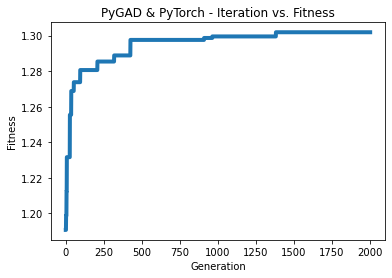

Epoch [1/4000] Loss: 4.5051  Accuracy: 55.00 %
Epoch [1001/4000] Loss: 0.3249  Accuracy: 90.28 %
Epoch [2001/4000] Loss: 0.1785  Accuracy: 96.94 %
Epoch [3001/4000] Loss: 0.1109  Accuracy: 98.89 %
Confusion matrix for training:
tensor([[174.,   4.],
        [  0., 182.]])


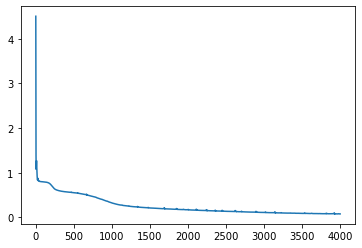

Testing Accuracy: 92.50 %
Confusion matrix for testing:
tensor([[21.,  1.],
        [ 2., 16.]])
Current k is  1 Test data are from  40  to  80
<function fitness_func at 0x7fcfb983dd30>


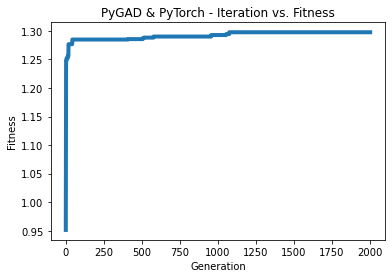

Epoch [1/4000] Loss: 3.0600  Accuracy: 53.06 %
Epoch [1001/4000] Loss: 0.4998  Accuracy: 79.44 %
Epoch [2001/4000] Loss: 0.2116  Accuracy: 95.56 %
Epoch [3001/4000] Loss: 0.1285  Accuracy: 98.89 %
Confusion matrix for training:
tensor([[175.,   3.],
        [  1., 181.]])


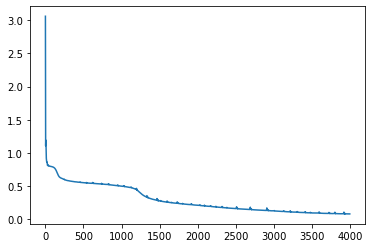

Testing Accuracy: 82.50 %
Confusion matrix for testing:
tensor([[17.,  5.],
        [ 2., 16.]])
Current k is  2 Test data are from  80  to  120
<function fitness_func at 0x7fcfb983dd30>


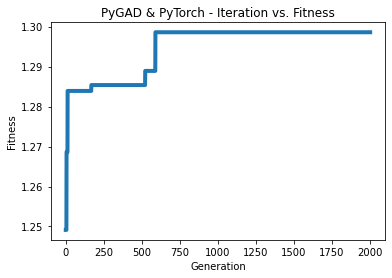

Epoch [1/4000] Loss: 5.8832  Accuracy: 51.94 %
Epoch [1001/4000] Loss: 0.5171  Accuracy: 80.28 %
Epoch [2001/4000] Loss: 0.2202  Accuracy: 94.72 %
Epoch [3001/4000] Loss: 0.1548  Accuracy: 98.06 %
Confusion matrix for training:
tensor([[175.,   4.],
        [  3., 178.]])


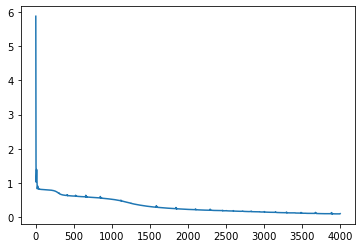

Testing Accuracy: 80.00 %
Confusion matrix for testing:
tensor([[17.,  4.],
        [ 4., 15.]])
Current k is  3 Test data are from  120  to  160
<function fitness_func at 0x7fcfb983dd30>


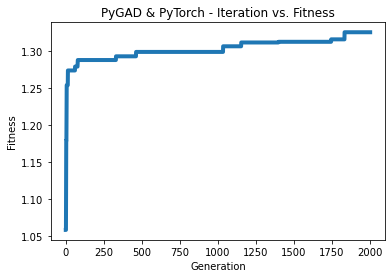

Epoch [1/4000] Loss: 5.7606  Accuracy: 58.33 %
Epoch [1001/4000] Loss: 0.4311  Accuracy: 85.00 %
Epoch [2001/4000] Loss: 0.1768  Accuracy: 96.39 %
Epoch [3001/4000] Loss: 0.1125  Accuracy: 98.61 %
Confusion matrix for training:
tensor([[176.,   3.],
        [  2., 179.]])


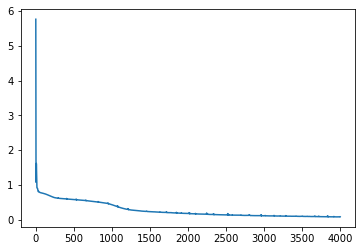

Testing Accuracy: 80.00 %
Confusion matrix for testing:
tensor([[18.,  3.],
        [ 5., 14.]])
Current k is  4 Test data are from  160  to  200
<function fitness_func at 0x7fcfb983dd30>


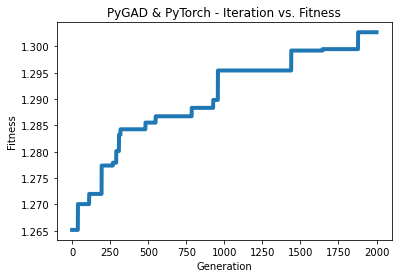

Epoch [1/4000] Loss: 3.7956  Accuracy: 54.17 %
Epoch [1001/4000] Loss: 0.5063  Accuracy: 80.28 %
Epoch [2001/4000] Loss: 0.2056  Accuracy: 94.44 %
Epoch [3001/4000] Loss: 0.1180  Accuracy: 98.06 %
Confusion matrix for training:
tensor([[180.,   3.],
        [  4., 173.]])


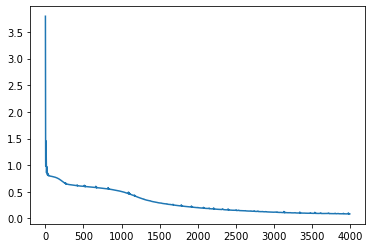

Testing Accuracy: 87.50 %
Confusion matrix for testing:
tensor([[16.,  1.],
        [ 4., 19.]])
Current k is  5 Test data are from  200  to  240
<function fitness_func at 0x7fcfb983dd30>


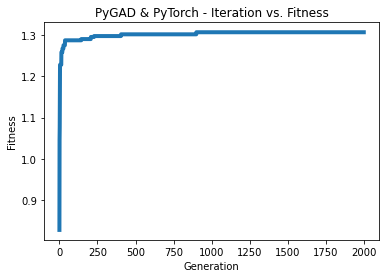

Epoch [1/4000] Loss: 8.4531  Accuracy: 57.22 %
Epoch [1001/4000] Loss: 0.5329  Accuracy: 76.11 %
Epoch [2001/4000] Loss: 0.2463  Accuracy: 93.06 %
Epoch [3001/4000] Loss: 0.1646  Accuracy: 96.11 %
Confusion matrix for training:
tensor([[177.,   8.],
        [  6., 169.]])


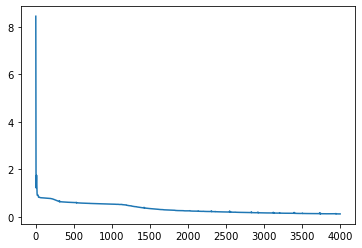

Testing Accuracy: 92.50 %
Confusion matrix for testing:
tensor([[14.,  1.],
        [ 2., 23.]])
Current k is  6 Test data are from  240  to  280
<function fitness_func at 0x7fcfb983dd30>


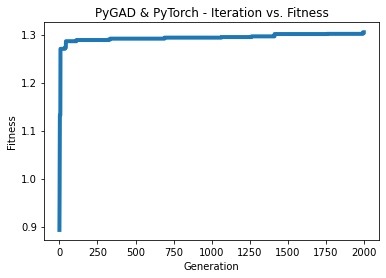

Epoch [1/4000] Loss: 3.6870  Accuracy: 53.06 %
Epoch [1001/4000] Loss: 0.2391  Accuracy: 94.72 %
Epoch [2001/4000] Loss: 0.1321  Accuracy: 98.89 %
Epoch [3001/4000] Loss: 0.0977  Accuracy: 99.72 %
Confusion matrix for training:
tensor([[183.,   1.],
        [  0., 176.]])


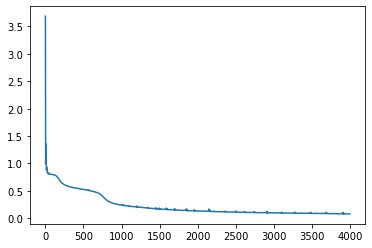

Testing Accuracy: 80.00 %
Confusion matrix for testing:
tensor([[12.,  4.],
        [ 4., 20.]])
Current k is  7 Test data are from  280  to  320
<function fitness_func at 0x7fcfb983dd30>


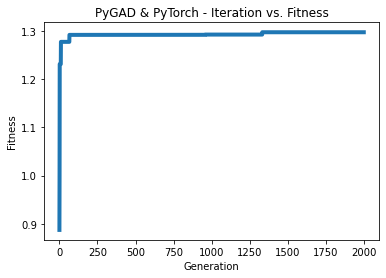

Epoch [1/4000] Loss: 12.1475  Accuracy: 58.61 %
Epoch [1001/4000] Loss: 0.5048  Accuracy: 79.44 %
Epoch [2001/4000] Loss: 0.2279  Accuracy: 93.61 %
Epoch [3001/4000] Loss: 0.1525  Accuracy: 97.78 %
Confusion matrix for training:
tensor([[175.,   5.],
        [  3., 177.]])


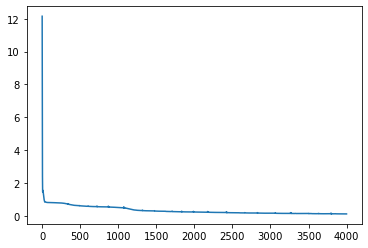

Testing Accuracy: 90.00 %
Confusion matrix for testing:
tensor([[19.,  1.],
        [ 3., 17.]])
Current k is  8 Test data are from  320  to  360
<function fitness_func at 0x7fcfb983dd30>


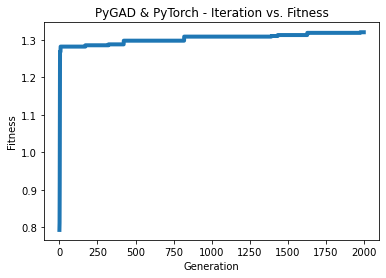

Epoch [1/4000] Loss: 15.8278  Accuracy: 56.67 %
Epoch [1001/4000] Loss: 0.5251  Accuracy: 77.50 %
Epoch [2001/4000] Loss: 0.2000  Accuracy: 96.39 %
Epoch [3001/4000] Loss: 0.1015  Accuracy: 99.44 %
Confusion matrix for training:
tensor([[177.,   2.],
        [  0., 181.]])


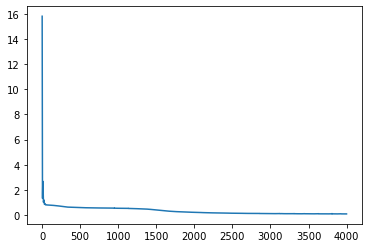

Testing Accuracy: 85.00 %
Confusion matrix for testing:
tensor([[17.,  4.],
        [ 2., 17.]])
Current k is  9 Test data are from  360  to  400
<function fitness_func at 0x7fcfb983dd30>


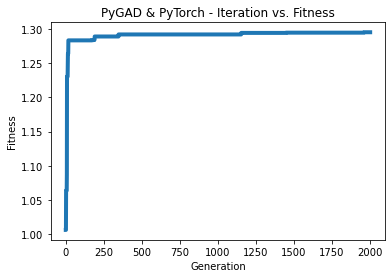

Epoch [1/4000] Loss: 4.7498  Accuracy: 51.39 %
Epoch [1001/4000] Loss: 0.5541  Accuracy: 72.22 %
Epoch [2001/4000] Loss: 0.2719  Accuracy: 92.50 %
Epoch [3001/4000] Loss: 0.1899  Accuracy: 96.67 %
Confusion matrix for training:
tensor([[166.,   9.],
        [  3., 182.]])


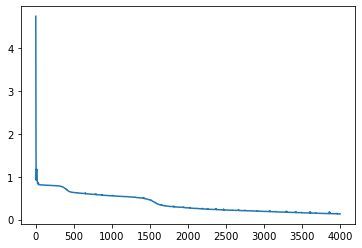

Testing Accuracy: 77.50 %
Confusion matrix for testing:
tensor([[19.,  6.],
        [ 3., 12.]])
The average accuracy is  84.75


In [78]:
# try shuffle data
data = data.sample(frac=1).reset_index(drop=True)

length=len(data)
accuracy=0
for i in range(0,10):
    print("Current k is ",i, "Test data are from ",int(i/10*length)," to ",int((i+1)/10*length))
    # split data into training set (80%) and testing set (20%)
    train_data = pd.concat([data.iloc[:int(i/10*length),:],data.iloc[int((i+1)/10*length):,:]])
    test_data = data.iloc[int(i/10*length):int((i+1)/10*length),:]
    
    
    
    # convert pandas dataframe to array
    data_array = train_data.values
    # split x (features) and y (targets)
    x_array = data_array[:, :n_features]
    # data_train = data_train.apply(pd.to_numeric)
    y_array = data_array[:, n_features:]
    # create Tensors to hold inputs and outputs. Tensors are data structures
    Y = torch.tensor(y_array.astype(float)).float()
    X = torch.tensor(x_array.astype(float)).float()
    # split output pattern into labels and extra node, for later calculation
    Y_class=Y[:,0]
    Y_node=Y[:,1]
    

    # bdnn model initialization
    model=BDNN(input_neurons, hidden_neurons, output_neurons)
    # define optimiser
    optimiser=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=2e-5)
    
    # Create an instance of the pygad.torchga.TorchGA class to build the initial population.
    torch_ga = torchga.TorchGA(model=model,num_solutions=20)

    # Stage 1: GA optimise BDNN weights and biases
    data_inputs=X
    data_outputs=Y
    
    # Prepare the PyGAD parameters
    num_generations = 2000 # Number of generations.
    num_parents_mating = 10 # Number of solutions to be selected as parents in the mating pool
    initial_population = torch_ga.population_weights # Initial population of network weights
    parent_selection_type = "sss" # Type of parent selection
    crossover_type = "single_point" # Type of the crossover operator
    crossover_probability=0.9 # The probability of crossover operator
    mutation_type = "random" # Type of the mutation operator
    mutation_percent_genes = 10# Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists.
    keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.
    
    print(fitness_func)
    # Create an instance of the pygad.GA class
    ga_instance = pygad.GA(num_generations=num_generations, 
                           num_parents_mating=num_parents_mating, 
                           initial_population=initial_population,
                           fitness_func=fitness_func,
                           parent_selection_type=parent_selection_type,
                           crossover_type=crossover_type,
                           crossover_probability=crossover_probability,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes,
                           keep_parents=keep_parents)

    # Start the genetic algorithm evolution.
    ga_instance.run()
    # After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
    ga_instance.plot_result(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

    # Returning the details of the best solution.
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    # Fetch the parameters of the best solution.
    best_solution_weights = torchga.model_weights_as_dict(model=model,
                                                          weights_vector=solution)
    model.load_state_dict(best_solution_weights)
    
    ### Stage 2: BDNN fine tuning
    
    # store all losses for visualisation
    all_losses = []

    # train a neural network
    for epoch in range(num_epoch):

        Y_pred = model(X)
        class_pre=Y_pred[:,0]
        extra_pre=Y_pred[:,1]

        loss1=loss_BCE(class_pre,Y_class)
        # back-propragation
        loss1.backward(retain_graph=True)

        loss2=loss_MSE(extra_pre,Y_node)
        loss2.backward(retain_graph=True)

        X_pred = model.reverseforward(Y)
        lb = F.mse_loss(X_pred, X)
        lb.backward()

        loss=loss1+loss2+lb
        all_losses.append(loss)

        # print progress
        if epoch % 1000 == 0:
            # convert output as probability via sigmoid
            predicted=F.sigmoid(Y_pred[:,0])
            result=np.round(predicted.data.numpy())
            # calculate and print accuracy
            total = predicted.size(0)
            correct = result== Y_class.data.numpy()
            print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
                  % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))
        if epoch==num_epoch-1:
            print('Confusion matrix for training:')
            print(plot_confusion(X.shape[0], output_neurons, torch.from_numpy(result).long().data, Y_class.long().data))

        # Calling the step function on an Optimiser makes an update to its parameters
        optimiser.step()
        # Clear the gradients before running the backward pass.
        model.zero_grad()
    plt.figure()
    plt.plot(all_losses)
    plt.show()
    
    #Testing 
    # convert pandas dataframe to array
    data_array = test_data.values
    x_array_test = data_array[:, :6]
    y_array_test = data_array[:, 6:]

    # create Tensors to hold inputs and outputs. Tensors are data structures
    Y_test = torch.tensor(y_array_test.astype(float)).float()
    X_test = torch.tensor(x_array_test.astype(float)).float()

    Y_class=Y_test[:,0]
    Y_node=Y_test[:,1]

    outputs = model(X_test)
    predicted=F.sigmoid(outputs[:,0])
    # print(predicted)

    total = predicted.size(0)
    result=np.round(predicted.data.numpy())

    correct = result == Y_class.data.numpy()
    print('Testing Accuracy: %.2f %%' % (100 * sum(correct)/total))
    print('Confusion matrix for testing:')
    print(plot_confusion(X_test.shape[0], output_neurons, torch.from_numpy(result).long().data, Y_class.long().data))
        
    accuracy+=(100 * sum(correct)/total)
print("The average accuracy is ",accuracy/10)
